# ALOS Demonstration over Samoa Island

In [1]:
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

import datacube
from utils.data_cube_utilities.data_access_api import DataAccessApi

In [2]:
dc_api = DataAccessApi(config = '/home/localuser/.datacube.conf')
dc = dc_api.dc

In [3]:
# Select one of the ALOS data cubes from around the world
# Colombia, Vietnam, Samoa Islands

## ALOS Data Summary
# There are 7 time slices (epochs) for the ALOS mosaic data. 
# The dates of the mosaics are centered on June 15 of each year (time stamp)
# Bands: RGB (HH-HV-HH/HV), HH, HV, date, incidence angle, mask)
# Years: 2007, 2008, 2009, 2010, 2015, 2016, 2017

platform = "ALOS-2"
product = "alos02_palsar02_scansar_samoa"

In [4]:
from utils.data_cube_utilities.dc_load import get_product_extents

full_lat, full_lon, min_max_dates = get_product_extents(dc_api, platform, product)

## Define Area Extents 

In [5]:
from datetime import datetime

# Apia City
# latitude_extents = (-13.7897, -13.8864)
# longitude_extents  = (-171.8531, -171.7171)

# East Area
# latitude_extents = -13.94, -13.84
# longitude_extents = -171.96, -171.8

# Central Area
# latitude_extents = -14.057, -13.884
# longitude_extents = -171.774, -171.573

# Small focused area in Central Region
latitude_extents = -13.9443, -13.884
longitude_extents = -171.6431, -171.573

A quick visualization of the area before it is loaded through the datacube 

In [6]:
from utils.data_cube_utilities.dc_display_map import display_map

display_map(latitude  = latitude_extents,
            longitude = longitude_extents)  

# Load Data  


In [7]:
dataset = dc.load(product = product, platform = platform, latitude = latitude_extents, longitude = longitude_extents)

In [8]:
dataset

<xarray.Dataset>
Dimensions:          (latitude: 268, longitude: 304, time: 7)
Coordinates:
  * time             (time) datetime64[ns] 2007-06-15 2008-06-15 ... 2017-06-15
  * latitude         (latitude) float64 -13.88 -13.88 -13.88 ... -13.94 -13.94
  * longitude        (longitude) float64 -171.6 -171.6 -171.6 ... -171.6 -171.6
Data variables:
    rgb              (time, latitude, longitude) int16 134 118 145 ... 149 142
    hh               (time, latitude, longitude) int16 5899 5259 ... 6485 6231
    hv               (time, latitude, longitude) int16 4022 3362 ... 5105 3552
    date             (time, latitude, longitude) int16 570 570 570 ... 1249 1249
    incidence_angle  (time, latitude, longitude) int16 41 40 40 40 ... 51 52 53
    mask             (time, latitude, longitude) int16 255 255 255 ... 255 255
Attributes:
    crs:      EPSG:4326

# View an acquisition in dataset

In [9]:
# Select a baseline and analysis time slice for comparison
# Make the adjustments to the years according to the following scheme
# Time Slice: 0=2007, 1=2008, 2=2009, 3=2010, 4=2015, 5=2016, 6=2017)

baseline_slice = dataset.isel(time = 0)
analysis_slice = dataset.isel(time = 6)

In [10]:
def figure_ratio(dataset, fixed_width = 10):
    width = fixed_width
    height = len(dataset.latitude) * (fixed_width / len(dataset.longitude))
    return (width, height)

In [11]:
%matplotlib inline
from utils.data_cube_utilities.dc_rgb import rgb

### View RGB for baseline and analysis period

(<Figure size 576x653.373 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1053c55f60>)

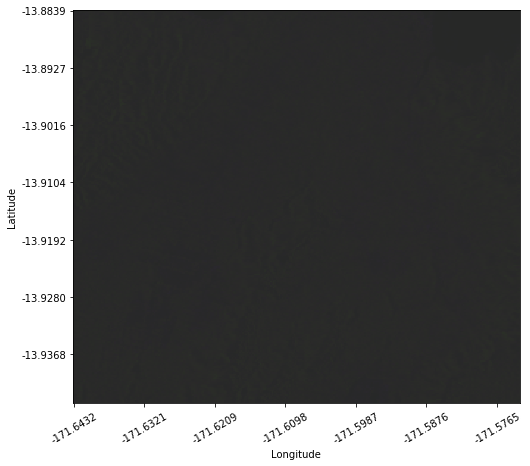

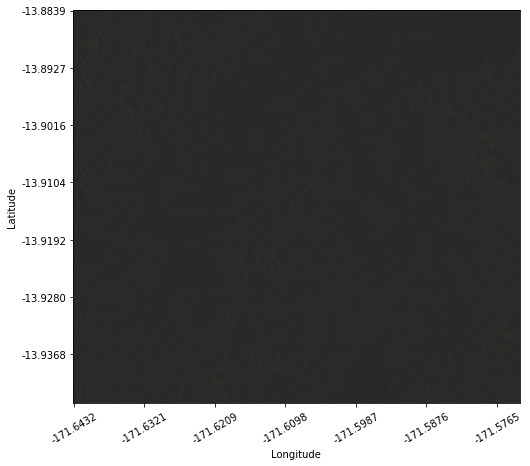

In [12]:
# Baseline RGB

rgb_dataset2 = xr.Dataset()
min_ = np.min([
    np.percentile(baseline_slice.hh,5),
    np.percentile(baseline_slice.hv,5),
])
max_ = np.max([
    np.percentile(baseline_slice.hh,95),
    np.percentile(baseline_slice.hv,95),
])
rgb_dataset2['base.hh'] = baseline_slice.hh.clip(min_,max_)/40
rgb_dataset2['base.hv'] = baseline_slice.hv.clip(min_,max_)/20
rgb_dataset2['base.ratio'] = (baseline_slice.hh.clip(min_,max_)/baseline_slice.hv.clip(min_,max_))*75
rgb(rgb_dataset2, bands=['base.hh','base.hv','base.ratio'], width=8)

# Analysis RGB

rgb_dataset2 = xr.Dataset()
min_ = np.min([
    np.percentile(analysis_slice.hh,5),
    np.percentile(analysis_slice.hv,5),
])
max_ = np.max([
    np.percentile(analysis_slice.hh,95),
    np.percentile(analysis_slice.hv,95),
])
rgb_dataset2['base.hh'] = analysis_slice.hh.clip(min_,max_)/40
rgb_dataset2['base.hv'] = analysis_slice.hv.clip(min_,max_)/20
rgb_dataset2['base.ratio'] = (analysis_slice.hh.clip(min_,max_)/analysis_slice.hv.clip(min_,max_))*75
rgb(rgb_dataset2, bands=['base.hh','base.hv','base.ratio'], width=8)

### Plot HH or HV band for baseline and analysis period
NOTE: The HV band is best for deforestation detection

Typical radar analyses convert the backscatter values at the pixel level to dB scale.<br>
The ALOS coversion (from JAXA) is: Backscatter dB = 20 * log10( backscatter intensity) - 83.0

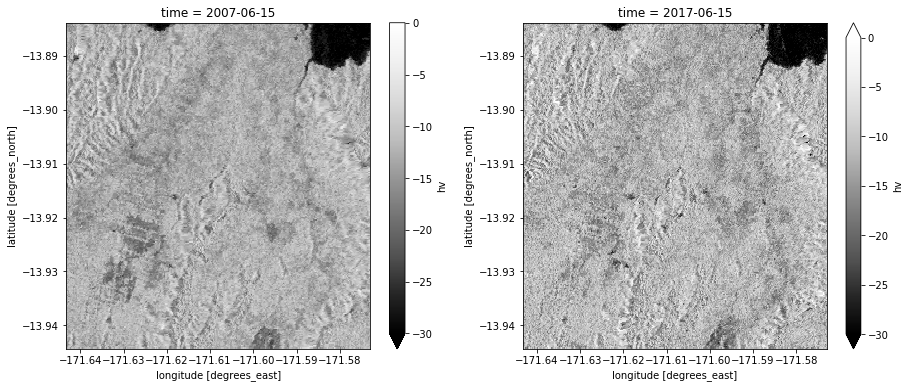

In [13]:
# Plot the BASELINE and ANALYSIS slice side-by-side
# Change the band (HH or HV) in the code below

plt.figure(figsize = (15,6))

plt.subplot(1,2,1)
(20*np.log10(baseline_slice.hv)-83).plot(vmax=0, vmin=-30, cmap = "Greys_r")
plt.subplot(1,2,2)
(20*np.log10(analysis_slice.hv)-83).plot(vmax=0, vmin=-30, cmap = "Greys_r")

### Plot a custom RGB that uses bands from the baseline and analysis periods
The RGB image below assigns RED to the baseline year HV band and GREEN+BLUE to the analysis year HV band<br>
Vegetation loss appears in RED and regrowth in CYAN. Areas of no change appear in different shades of GRAY.<br>
Users can change the RGB color assignments and bands (HH, HV) in the code below

(<Figure size 576x653.373 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f10522b1cf8>)

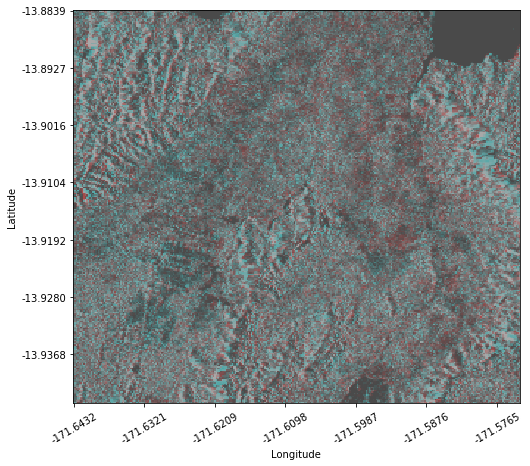

In [14]:
# Clipping the bands uniformly to brighten the image
rgb_dataset2 = xr.Dataset()
min_ = np.min([
    np.percentile(baseline_slice.hv,5),
    np.percentile(analysis_slice.hv,5),
])
max_ = np.max([
    np.percentile(baseline_slice.hv,95),
    np.percentile(analysis_slice.hv,95),
])
rgb_dataset2['baseline_slice.hv'] = baseline_slice.hv.clip(min_,max_)
rgb_dataset2['analysis_slice.hv'] = analysis_slice.hv.clip(min_,max_)

# Plot the RGB with clipped HV band values
rgb(rgb_dataset2, bands=['baseline_slice.hv','analysis_slice.hv','analysis_slice.hv'], width=8)

### Select one of the plots below and adjust the threshold limits (top and bottom)

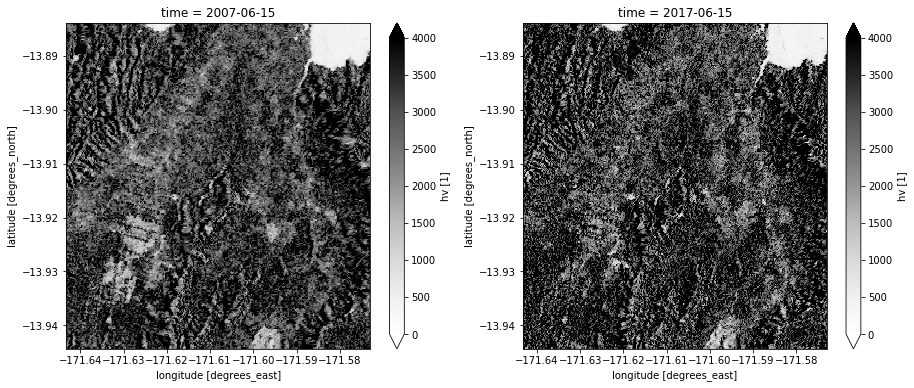

In [15]:
plt.figure(figsize = (15,6))
plt.subplot(1,2,1)
baseline_slice.hv.plot (vmax=0, vmin=4000, cmap="Greys")
plt.subplot(1,2,2)
analysis_slice.hv.plot (vmax=0, vmin=4000, cmap="Greys")

### Plot a change product to compare two time periods (epochs)

In [16]:
from matplotlib.ticker import FuncFormatter

def intersection_threshold_plot(first, second, th, mask = None, color_none=np.array([0,0,0]), 
                                color_first=np.array([0,255,0]), color_second=np.array([255,0,0]), 
                                color_both=np.array([255,255,255]), color_mask=np.array([127,127,127]), 
                                width = 10, *args, **kwargs):
    """
    Given two dataarrays, create a threshold plot showing where zero, one, or both are within a threshold.
    
    Parameters
    ----------
    first, second: xarray.DataArray
        The DataArrays to compare.
    th: tuple
        A 2-tuple of the minimum (inclusive) and maximum (exclusive) threshold values, respectively.
    mask: numpy.ndarray
        A NumPy array of the same shape as the dataarrays. The pixels for which it is `True` are colored `color_mask`.
    color_none: list-like
        A list-like of 3 elements - red, green, and blue values in range [0,255], used to color regions where neither
        first nor second have values within the threshold. Default color is black.
    color_first: list-like
        A list-like of 3 elements - red, green, and blue values in range [0,255], used to color regions where only the first 
        has values within the threshold. Default color is green.
    color_second: list-like
        A list-like of 3 elements - red, green, and blue values in range [0,255], used to color regions where only the second
        has values within the threshold. Default color is red.
    color_both: list-like
        A list-like of 3 elements - red, green, and blue values in range [0,255], used to color regions where both the
        first and second have values within the threshold. Default color is white.
    color_mask: list-like
        A list-like of 3 elements - red, green, and blue values in range [0,255], used to color regions where `mask == True`.
        Overrides any other color a region may have. Default color is gray.
    width: int
        The width of the created ``matplotlib.figure.Figure``.
    *args: list
        Arguments passed to ``matplotlib.pyplot.imshow()``.
    **kwargs: dict
        Keyword arguments passed to ``matplotlib.pyplot.imshow()``.
    """
    mask  = np.zeros(first.shape).astype(bool) if mask is None else mask
    
    first_in = np.logical_and(th[0] <= first, first < th[1])
    second_in = np.logical_and(th[0] <= second, second < th[1])
    both_in = np.logical_and(first_in, second_in)
    none_in = np.invert(both_in)
    
    # The colors for each pixel.
    color_array = np.zeros((*first.shape, 3)).astype(np.int16)
    
    color_array[none_in] = color_none
    color_array[first_in] =  color_first
    color_array[second_in] = color_second
    color_array[both_in] = color_both
    color_array[mask] =  color_mask

    def figure_ratio(ds, fixed_width = 10):
        width = fixed_width
        height = len(ds.latitude) * (fixed_width / len(ds.longitude))
        return (width, height)

    fig, ax = plt.subplots(figsize = figure_ratio(first,fixed_width = width))
    
    lat_formatter = FuncFormatter(lambda y_val, tick_pos: "{0:.3f}".format(first.latitude.values[tick_pos] ))
    lon_formatter = FuncFormatter(lambda x_val, tick_pos: "{0:.3f}".format(first.longitude.values[tick_pos]))

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    
    plt.title("Threshold: {} < x < {}".format(th[0], th[1]))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    plt.imshow(color_array, *args, **kwargs)
    plt.show()

In [17]:
change_product_band = 'hv'
baseline_epoch = "2007-06-15"
analysis_epoch = "2017-06-15"
threshold_range = (0, 2000) # The minimum and maximum threshold values, respectively.

baseline_ds = dataset.sel(time=baseline_epoch)[change_product_band]
analysis_ds = dataset.sel(time=analysis_epoch)[change_product_band]

anomaly = analysis_ds - baseline_ds

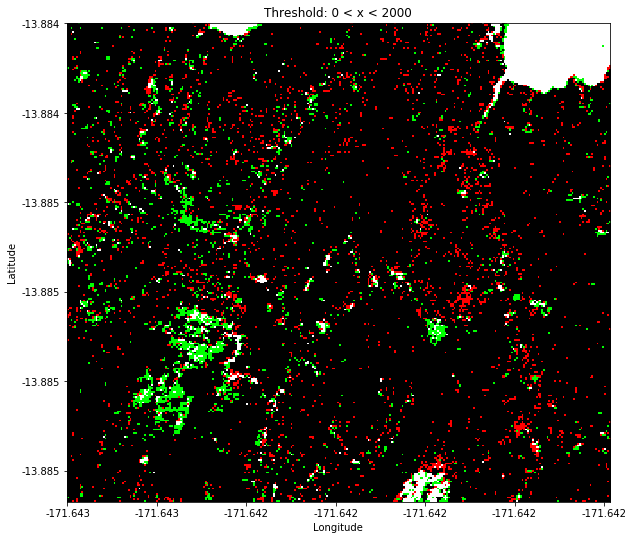

In [18]:
intersection_threshold_plot(baseline_ds, analysis_ds, threshold_range)